Download colab_utils and import



<a href="https://colab.research.google.com/github/beangoben/intro_dl/blob/master/Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [30]:
!wget https://raw.githubusercontent.com/beangoben/workshop_template/master/colab_utils.py -O colab_utils.py
!rm -rf sample_data
import colab_utils
!pip install flax
!pip install umap-learn

--2020-08-25 17:18:37--  https://raw.githubusercontent.com/beangoben/workshop_template/master/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7173 (7.0K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   7.00K  --.-KB/s    in 0s      

2020-08-25 17:18:37 (81.8 MB/s) - ‘colab_utils.py’ saved [7173/7173]



# Importa modulos


In [62]:
from collections import OrderedDict
import tqdm.auto as tqdm
import colab_utils

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import umap
import sklearn
# Jax
import jax
from jax import numpy as jnp, random, jit, lax
# Flax
import flax
from flax import nn, optim
# Tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds

_ = jnp.square(2.)

colab_utils.print_module_versions([tf, tfds, jax])
colab_utils.matplotlib_settings()

tensorflow: 2.3.0
tensorflow_datasets: 2.1.0
jax       : 0.1.75


Primero lodearemos algunos datos

In [ ]:
train_ds = train_ds.map(lambda x: {'image': tf.cast(x['image'], tf.float32),
                                    'label': tf.cast(x['label'], tf.int32)})
train_ds = train_ds.cache().shuffle(1000).batch(128)

train_ds = {'image': x_train.astype(jnp.float32),
            'label': y_train.astype(jnp.int32)}
test_ds = {'image': test_ds['image'].astype(jnp.float32),
            'label': test_ds['label'].astype(jnp.int32)}

In [39]:
#dataset = 'fashion_mnist'
dataset_name = 'mnist'

train_ds = tfds.as_numpy(tfds.load(dataset_name, split=tfds.Split.TRAIN, batch_size=-1))
x_train, y_train = train_ds['image'], train_ds['label']

test_ds = tfds.as_numpy(tfds.load(dataset_name, split=tfds.Split.TEST, batch_size=-1))
x_test, y_test = test_ds['image'], test_ds['label']

# Necesitamos DL? Primero EDA!

In [48]:
def flatten_image(x):
    return np.reshape(x, (x.shape[0],x.shape[1]*x.shape[2]))

flat_x_train = flatten_image(x_train)
flat_y_train = y_train.ravel()

flat_x_test = flatten_image(x_test)
flat_y_test = y_test.ravel()
print(flat_x_train.shape, y_train.shape)
print(flat_x_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


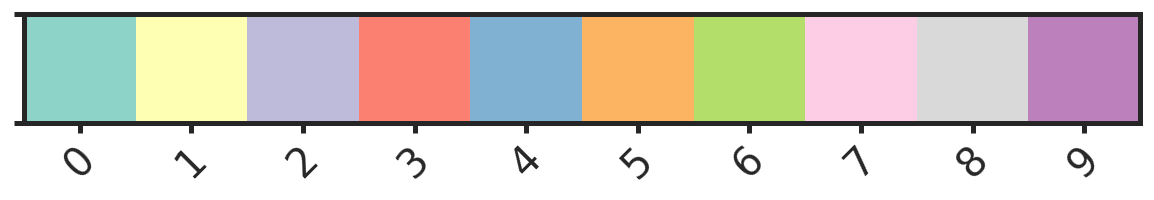

In [49]:
def labels_to_nodecolors(labels):
    """Convierte etqiuetas a colores."""
    cols = sns.color_palette("Set3", 10)
    return [cols[int(l)] for l in labels.ravel()]

def plot_color_legend(dataset_name):
    cols = sns.color_palette("Set3", 10)
    categories = {'fashion_mnist':['T-shirt/top','Trouser',
                                   'Pullover','Dress', 'Coat','Sandal',
               'Shirt','Sneaker','Bag','Ankle boot'],
               'mnist': list(range(10))}[dataset_name]
    sns.palplot(cols)
    plt.xticks(np.arange(10), categories, rotation=45)
    plt.show()
    
plot_color_legend(dataset_name)

In [55]:
import sklearn.pipeline
import sklearn.decomposition
import sklearn.preprocessing

pca_pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()),
                                  ('dim_reduce', sklearn.decomposition.PCA(2))])

umap_pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()),
                                  ('dim_reduce', umap.UMAP())])

umap_pipe.fit(flat_x_train)
x_umap = umap_pipe.transform(flat_x_test)

pca_pipe.fit(flat_x_train)
x_pca = pca_pipe.transform(flat_x_test)

print(x_umap.shape, x_pca.shape)

(10000, 2) (10000, 2)


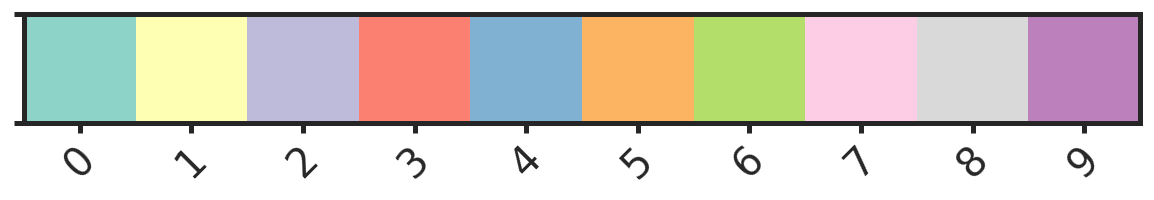

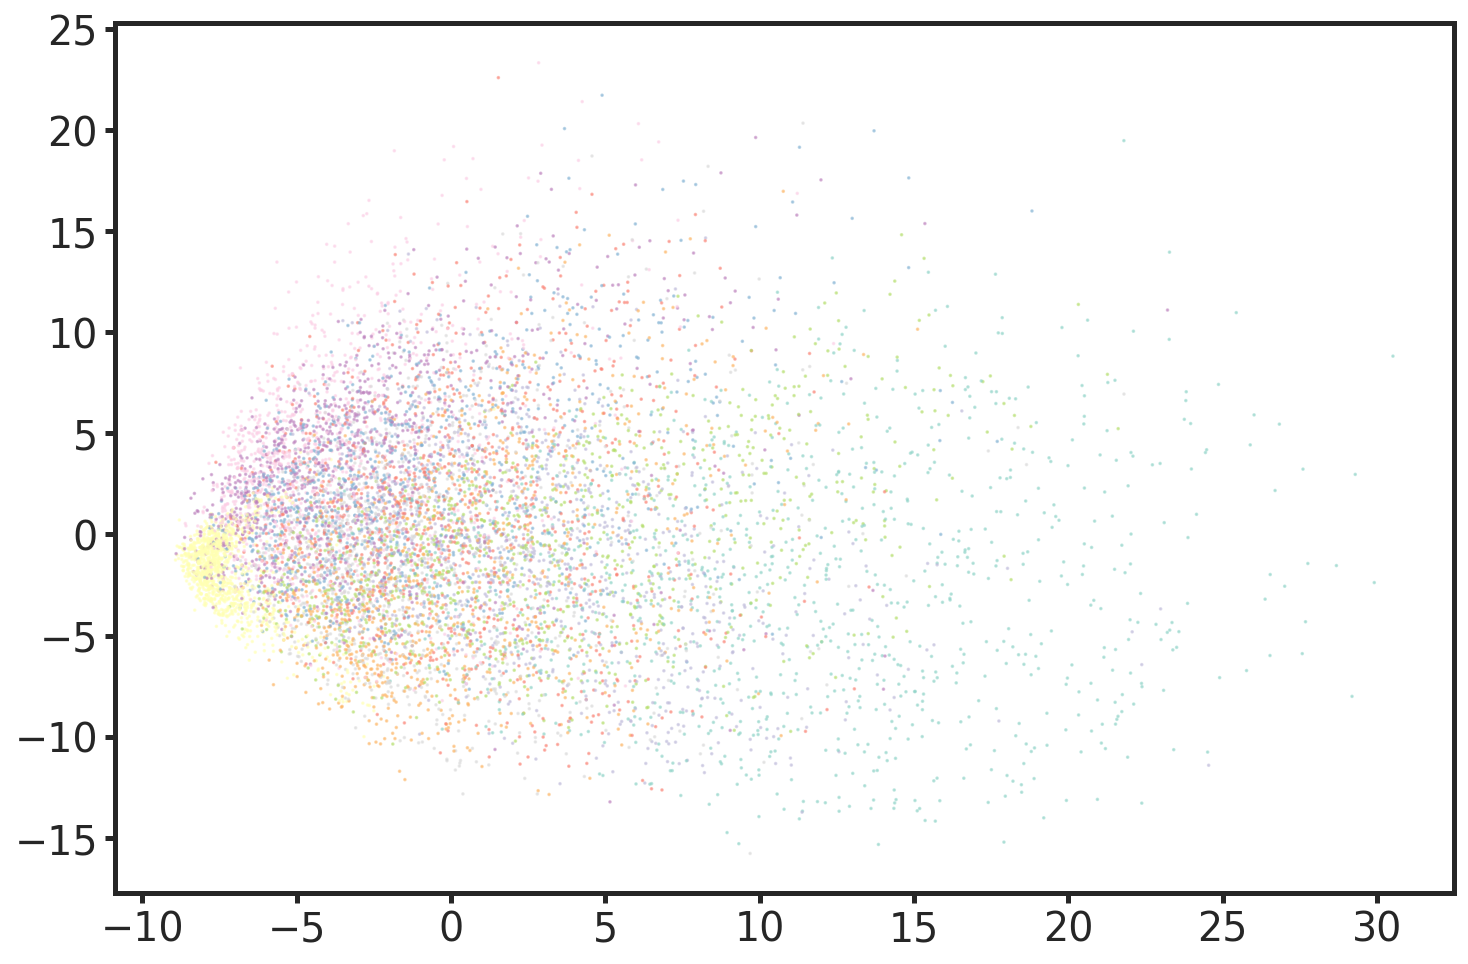

In [63]:
plot_color_legend(dataset_name)
plt.scatter(x_pca[:,0], x_pca[:, 1],
            c=labels_to_nodecolors(flat_y_test),
            s=1, alpha=0.5)
plt.show()

In [58]:
indices = np.random.permutation(len(x_umap))[:5000]

vis_df = pd.DataFrame()
vis_df['UMAP1'] = x_umap[indices, 0]
vis_df['UMAP2'] = x_umap[indices, 1]
vis_df['PC1'] = x_pca[indices, 0]
vis_df['PC2'] = x_pca[indices, 1]
vis_df['label'] = flat_y_test[indices]
vis_df

,UMAP1,UMAP2,PC1,PC2,label
0,7.885428,4.227294,0.755570,3.434424,2
1,-1.101386,3.794458,3.230337,-1.366293,8
2,-7.054633,3.163792,-8.190725,-1.709466,1
3,-1.738566,11.840984,-4.177603,5.262380,7
4,-0.456391,13.002729,-6.999848,1.495790,7
...,...,...,...,...,...
4995,7.815452,-2.205658,1.031436,4.159793,6
4996,-0.317288,4.421916,-3.303010,1.893841,8
4997,5.645652,1.568008,1.236294,-9.842185,2
4998,1.053415,3.091951,-5.267032,7.336266,3


In [61]:
alt.Chart(vis_df).mark_circle(size=10).encode(
    x='UMAP1:Q',
    y='UMAP2:Q',
    color='label:N',
    tooltip=['label']
).interactive()

NameError: ignored